In [1]:
%matplotlib widget
import os  
import sys  
sys.path.insert(0, os.getenv('HOME')+'/pycode/MscThesis/')
from amftrack.pipeline.functions.post_processing.extract_study_zone import *
import pandas as pd
import ast
from amftrack.plotutil import plot_t_tp1
from scipy import sparse
from datetime import datetime
import pickle
import scipy.io as sio
from pymatreader import read_mat
from matplotlib import colors
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import frangi
from skimage import filters
from random import choice
import scipy.sparse
import os
from skimage.feature import hessian_matrix_det
from amftrack.pipeline.paths.directory import run_parallel, find_state, directory_scratch, directory_project
from amftrack.notebooks.analysis.util import * 
from scipy import stats
from scipy.ndimage.filters import uniform_filter1d
from collections import Counter
from IPython.display import clear_output
from amftrack.notebooks.analysis.data_info import *
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
plt.rcParams.update({
    "font.family": "verdana",
'font.weight' : 'normal',
'font.size': 20})
from amftrack.plotutil import plot_node_skel
from amftrack.notebooks.validation.util import *
from amftrack.pipeline.paths.directory import *
from amftrack.util import *
import pickle
from amftrack.pipeline.functions.post_processing.extract_study_zone import load_study_zone
from amftrack.pipeline.functions.post_processing.time_hypha import *
from amftrack.pipeline.functions.image_processing.experiment_class_surf import Experiment, save_graphs, load_graphs, load_skel
from amftrack.pipeline.functions.image_processing.experiment_class_surf import Edge

from shapely.geometry import Polygon, shape,Point
from scipy import spatial
from sklearn.preprocessing import StandardScaler


/home/cbisot/pycode/MscThesis/amftrack/transfer/functions/transfer.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
directory = directory_project
# update_analysis_info(directory)
analysis_info = get_analysis_info(directory)

In [3]:
select = analysis_info 
num = 2
rows = [row for (index, row) in select.iterrows()]
for index,row in enumerate(rows):
    path = f'{directory}{row["folder_analysis"]}'
    print(index,row["Plate"])
    try:
        a = np.load(f'{path}/center.npy')
    except:
        print(index,row["Plate"])
    if index == num:
        path_exp = f'{directory}{row["path_exp"]}'
        exp = pickle.load(open(path_exp, "rb"))
        exp.dates.sort()
        break

0 799
1 790
2 792


In [5]:
API = str(np.load(os.getenv('HOME')+'/pycode/API_drop.npy'))


In [7]:
upload(API,path_exp,'/trash')

Uploaded:   0%|          | 0/44795227 [00:00<?, ?it/s]

ApiError: ApiError('1fcaa427164b4d59947bcd0e439b69f4', UploadSessionFinishError('path', WriteError('conflict', WriteConflictError('folder', None))))

In [4]:
load_study_zone(exp)
load_graphs(exp,labeled=True,indexes = [0])

In [5]:
time_hypha_info = pd.read_pickle("time_hypha_infos.pick")
time_plate_info = pd.read_pickle("time_plate_infos.pick")
global_hypha_info = pd.read_pickle("global_hypha_info.pick")


In [6]:
plates = time_plate_info['Plate'].unique()
ind_plate_table_time = {}
for plate in plates:
    ind_plate_table_time[plate]=time_plate_info.loc[time_plate_info['Plate']==plate].copy()

In [7]:
plates = time_plate_info['Plate'].unique()
ind_plate_table = {}
for plate in plates:
    ind_plate_table[plate]=time_plate_info.loc[time_plate_info['Plate']==plate].copy()
    

In [8]:
plates = global_hypha_info['Plate'].unique()
ind_hypha_table = {}
for plate in plates:
    table = global_hypha_info.loc[global_hypha_info['Plate']==plate].copy()
    table = table.set_index('hypha')
    ind_hypha_table[plate]=table

In [9]:
for plate in plates:
    table = ind_plate_table[plate]
    table['total_length_m'] = table['tot_length_study']/10**6
    table['speed'] = table['tot_length_study'].diff(5)/table['time_since_begin'].diff(5)
    table['mean_step'] = np.mean(table['time_since_begin'].diff(1))
    table['density'] = table['tot_length_study']/(table['area_sep_comp']+1)
    table['ring_density'] = table['tot_length_study'].diff(10)/(table['area_sep_comp'].diff(10)+1)
    table['log_length_study'] = np.log2(table['tot_length_study'].astype(float))
    table['local_growth_rate'] = table['log_length_study'].diff(5)/table['time_since_begin'].diff(5)*24
    table_hypha = ind_hypha_table[plate]

/home/cbisot/miniconda3/envs/amftrack/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [10]:
plates = time_hypha_info['Plate'].unique()
time_hypha_table = {}
for plate in plates: 
    time_hypha_table[plate]=global_hypha_info.loc[global_hypha_info['Plate']==plate].copy()
    select_time_plate = ind_plate_table[plate]
    last_time = np.max(select_time_plate.loc[select_time_plate['out_study']==0]['time_since_begin'])
    last_time2 = np.max(select_time_plate.loc[select_time_plate['local_growth_rate']>=0.5]['time_since_begin'])
    select_time = time_hypha_info.loc[time_hypha_info['Plate']==plate]
    select_time = select_time.loc[select_time['speed'].between(0,400)]
    select_global = global_hypha_info.loc[global_hypha_info['Plate']==plate]
    select_time = select_time.loc[select_time['has_reached_final_pos']=='False']
    select_time = select_time.loc[select_time['distance_final_pos']>200]
    select_time = select_time.loc[select_time['in_ROI']=='True']
    select_time = select_time.loc[select_time['time_since_begin_exp']<=last_time2]
    select_time['speed'] = select_time['speed'].astype(float)
    time_hypha_table[plate] = select_time

In [11]:
plate = 94
table = ind_hypha_table[plate]
table_time = time_hypha_table[plate]
select_time = time_hypha_info.loc[time_hypha_info['Plate']==plate]
speed_at_init = table_time.loc[table_time['time_since_emergence']==0]
table['max_speed'] = table_time.groupby('end')['speed'].max()
table['mean_speed2'] = table_time.groupby('end')['speed'].mean()
table['log_length'] = np.log10((table['tot_length_C']+1).astype(float))
table['log_growth'] = np.log10((table['tot_growth_C']+1).astype(float))

table['growth_lapse'] = table_time.groupby('end')['speed'].count()
table['speed_at_init'] = speed_at_init.groupby('end')['speed'].max()
# table = table.loc[table['max_speed'].notnull()]
table = table.loc[table['av_width_final'].between(0,15)]
# table = table.loc[table['num_branch']>=0]
# table = table.loc[table['tot_growth_C']>=200]

# table['branch_frequ'] = table['num_branch']/(table['tot_growth_C']+1)
# table = table.loc[table['branch_frequ'].between(0,0.003)]


/home/cbisot/miniconda3/envs/amftrack/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


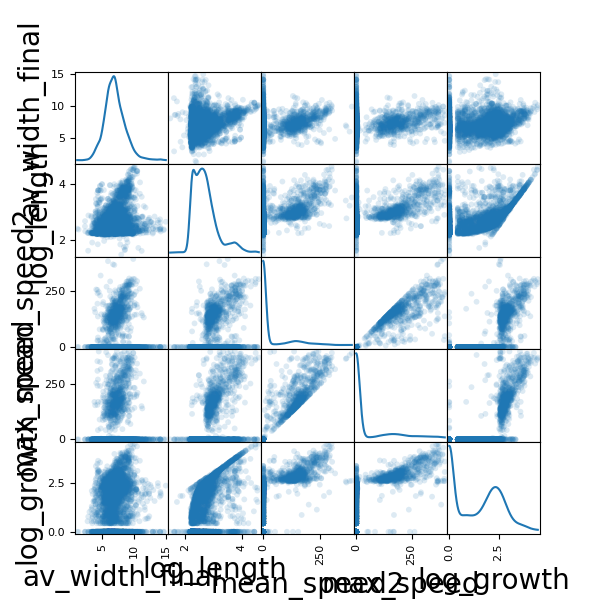

In [94]:
from pandas.plotting import scatter_matrix
scatter_matrix(table[['av_width_final','log_length','mean_speed2','max_speed','log_growth']].fillna(0), alpha=0.15, figsize=(6, 6), diagonal="kde",s=70);

In [12]:
plate = 76
table = ind_hypha_table[plate]
table_time = time_hypha_table[plate]
select_time = time_hypha_info.loc[time_hypha_info['Plate']==plate]
speed_at_init = table_time.loc[table_time['time_since_emergence']==0]
table['max_speed'] = table_time.groupby('end')['speed'].max()
table['mean_speed2'] = table_time.groupby('end')['speed'].mean()
table['log_length'] = np.log10((table['tot_length_C']+1).astype(float))
table['growth_lapse'] = table_time.groupby('end')['speed'].count()
table['speed_at_init'] = speed_at_init.groupby('end')['speed'].max()
# table = table.loc[table['max_speed'].notnull()]
table = table.loc[table['av_width_final'].between(0,15)]
# table = table.loc[table['num_branch']>=1]
# table['branch_frequ'] = table['num_branch']/table['tot_length_C']
# table = table.loc[table['branch_frequ']<0.003]
from sklearn.cluster import KMeans
df = table[['log_length']].fillna(0)
features = ['log_length']# Separating out the features
# features = ['log_length','mean_speed2']# Separating out the features

x = table.loc[:, features].values# Separating out the target
# y = table.loc[:,['target']].values# Standardizing the features
x = StandardScaler().fit_transform(x)
kmeans = KMeans(n_clusters=3).fit(x)
centroids = kmeans.cluster_centers_
c= kmeans.labels_.astype(float)

table['category'] = c
table['is_rh'] = (table['category']==table.groupby('category')['max_speed'].mean().idxmax()).astype(int)
table['is_rh'] = (table['log_length']>=3.36).astype(int)
table['is_small'] = (table['log_length']<=2.3).astype(int)

/home/cbisot/miniconda3/envs/amftrack/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/cbisot/miniconda3/envs/amftrack/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/cbisot/miniconda3/envs/amftrack/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


<AxesSubplot:title={'center':'76'}, xlabel='log_length', ylabel='av_width_final'>

Text(0, 0.5, 'average width $(\\mu m)$')

Text(0.5, 0, 'log length $(log(\\mu m))$')

findfont: Font family ['verdana'] not found. Falling back to DejaVu Sans.
findfont: Font family ['verdana'] not found. Falling back to DejaVu Sans.


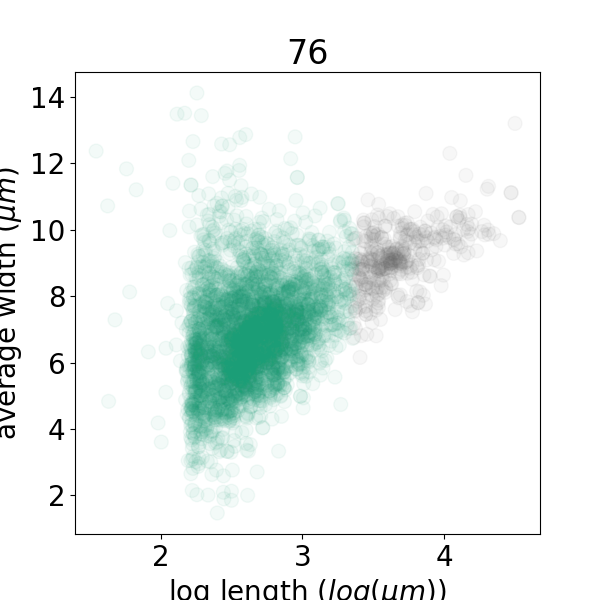

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ylabel = 'average width $(\mu m)$'
# ylabel = 'maximum speed $(\mu m.s^{-1})$'
xlabel = 'log length $(log(\mu m))$'

table.plot('log_length','av_width_final',c='is_rh',kind='scatter',colormap='Dark2',alpha = 0.05,s=100,ax=ax,title = plate,colorbar = False)
ax.set_ylabel(ylabel)
ax.set_xlabel(xlabel)
# ax.set_xlim(2.5,4.5)
# ax.set_ylim(50,400)

In [80]:
len([hyph for hyph in exp.hyphaes if hyph.end.is_in(t)])

1509

In [15]:
skels = []
ims = []
kernel = np.ones((5,5),np.uint8)
itera = 2
folders = list(exp.folders['folder'])
folders.sort()
for folder in folders[-1:]:
    directory_name=folder
    path_snap=directory+directory_name
    skel_info = read_mat(path_snap+'/Analysis/skeleton_realigned_compressed.mat')
    skel = skel_info['skeleton']
    skels.append(cv2.dilate(skel.astype(np.uint8),kernel,iterations = itera))

In [16]:
segs = []
t=-1
colors = []
for hyph in exp.hyphaes:
    try:
        nodes,edges = hyph.get_nodes_within(t)
        color = "red" if np.all(table.loc[table.index == hyph.end.label]['is_rh']) else "blue"
        color = 'green' if np.all(table.loc[table.index == hyph.end.label]['is_small']) else color
        for edge in edges:
            origin, end = edge.end.get_pseudo_identity(t).pos(t),edge.begin.get_pseudo_identity(t).pos(t)
            segs.append((origin, end))
            colors.append(color)
    except nx.exception.NetworkXNoPath:
        pass

In [17]:
segs = [(np.flip(origin)//5,np.flip(end)//5) for origin,end in segs]


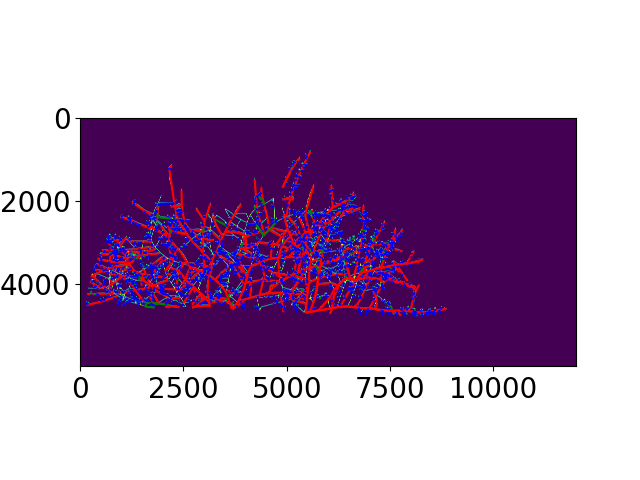

In [18]:
plt.close('all')
import matplotlib
i=0
ln_coll = matplotlib.collections.LineCollection(segs,colors=colors)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(skels[i])
ax.add_collection(ln_coll)
plt.draw()